In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Se importan las librerias que se utilizaran:

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from random import randint
import keras.utils as utils
from google.colab.patches import cv2_imshow
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam
from keras import backend as K
print(tf.__version__)
import itertools
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

TensorFlow 1.x selected.


Using TensorFlow backend.


1.15.2


En la etapa de obtención de datos, se recoletaron 1000 imagenes de 256x256 por cada uno de los 4 stages de cada mundo a clasificar. Es decir para el mundo 1 existe 4000 imagenes y para el mundo 2 tambien 4000 imagenes. De esta manera aseguramos un problema balanceado.

Las imagenes fueron guardadas en un arreglo de matrices de numeros que representan cada pixel de la imagen segun su codificación RGB, por esto es un arreglo de 4 dimensiones. Ademas se guardaron las imagenes en un arreglo, esto evita utilizar tiempo y recursos computacionales cada vez que se requiera ajustar parametros de la red.

Se procede a cargar los datos de las imagenes de esos archivos.

In [0]:
PATH = os.getcwd()
loaded_xarray = np.load(PATH+'/drive/My Drive/Colab Notebooks/Machine Learning/Proyecto 1/Arreglos/Problema Facil/Xnumpyarray.npy')
loaded_yarray=np.load(PATH+'/drive/My Drive/Colab Notebooks/Machine Learning/Proyecto 1/Arreglos/Problema Facil/Ynumpyarray.npy')

Se verifica que la persistencia de los datos no haya modificado las imagenes, por lo tanto se muestran aleatoriamente algunas de las imagenes cargadas.

In [0]:
def cualClase(claseBinaria):
  clase=''
  if claseBinaria==0:
    clase='Mundo 2'
  else:
    clase='Mundo 1'
  return clase

El tamaño de X es:  (8280, 256, 256, 3)
El tamaño de Y es:  (8280,)
Algunos de los datos.... 

-----------------------------------------------------
Imagen #:  516 



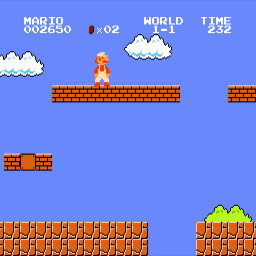

Pertenece a la clase:  Mundo 1 

-----------------------------------------------------
Imagen #:  2191 



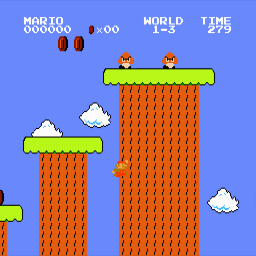

Pertenece a la clase:  Mundo 1 

-----------------------------------------------------
Imagen #:  3015 



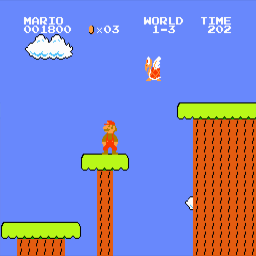

Pertenece a la clase:  Mundo 1 

-----------------------------------------------------
Imagen #:  1276 



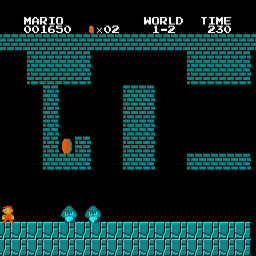

Pertenece a la clase:  Mundo 1 

-----------------------------------------------------
Imagen #:  8090 



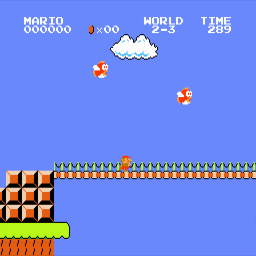

Pertenece a la clase:  Mundo 2 

-----------------------------------------------------
Imagen #:  3942 



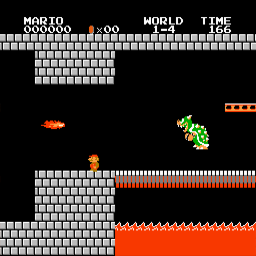

Pertenece a la clase:  Mundo 1 

-----------------------------------------------------
Imagen #:  6033 



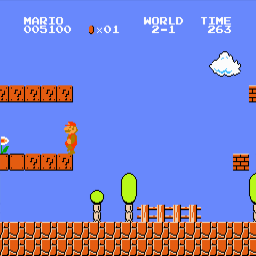

Pertenece a la clase:  Mundo 2 

-----------------------------------------------------
Imagen #:  6167 



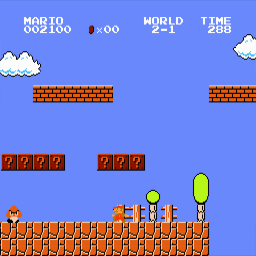

Pertenece a la clase:  Mundo 2 

-----------------------------------------------------
Imagen #:  7213 



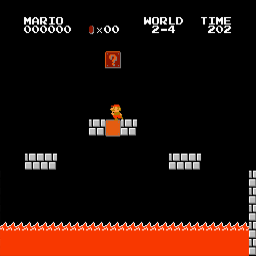

Pertenece a la clase:  Mundo 2 

-----------------------------------------------------
Imagen #:  4226 



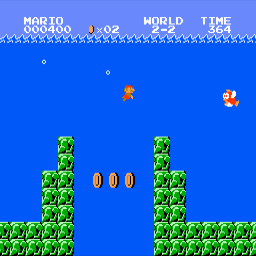

Pertenece a la clase:  Mundo 2 

-----------------------------------------------------
Imagen #:  3728 



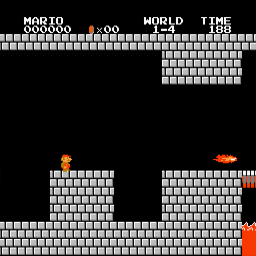

Pertenece a la clase:  Mundo 1 

-----------------------------------------------------
Imagen #:  4467 



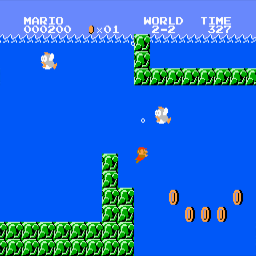

Pertenece a la clase:  Mundo 2 

-----------------------------------------------------
Imagen #:  6368 



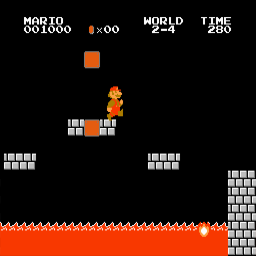

Pertenece a la clase:  Mundo 2 

-----------------------------------------------------
Imagen #:  4515 



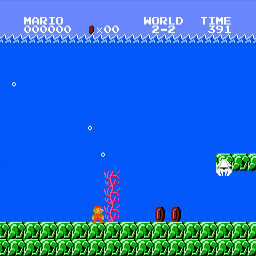

Pertenece a la clase:  Mundo 2 

-----------------------------------------------------
Imagen #:  1118 



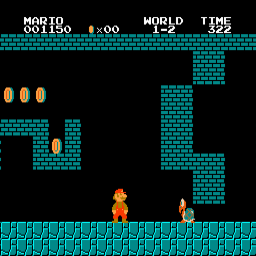

Pertenece a la clase:  Mundo 1 

-----------------------------------------------------
Imagen #:  2784 



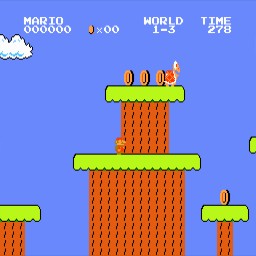

Pertenece a la clase:  Mundo 1 

-----------------------------------------------------
Imagen #:  620 



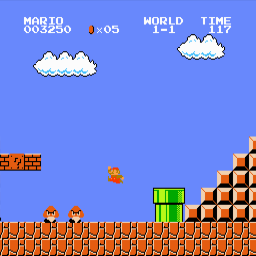

Pertenece a la clase:  Mundo 1 

-----------------------------------------------------
Imagen #:  6084 



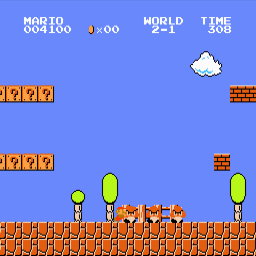

Pertenece a la clase:  Mundo 2 

-----------------------------------------------------
Imagen #:  1656 



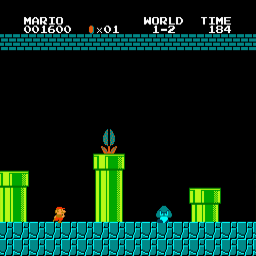

Pertenece a la clase:  Mundo 1 

-----------------------------------------------------
Imagen #:  2070 



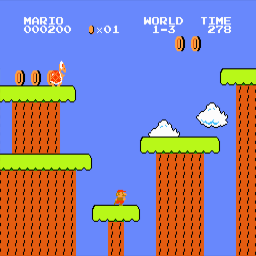

Pertenece a la clase:  Mundo 1 



In [0]:
print('El tamaño de X es: ',loaded_xarray.shape)
print('El tamaño de Y es: ',loaded_yarray.shape)
print('Algunos de los datos.... \n')
for i in range(20):
  numAleatorio=randint(0,loaded_xarray.shape[0]-1)
  print('-----------------------------------------------------')
  print('Imagen #: ',numAleatorio ,'\n')
  cv2_imshow(loaded_xarray[numAleatorio])
  claseBinaria=loaded_yarray[numAleatorio]
  clase=cualClase(claseBinaria)
  print('Pertenece a la clase: ',clase,'\n')

Se verifica que el problema sea balanceado

In [0]:
zeros=0
ones=0
for i in loaded_yarray:
  if i==0:
    zeros+=1
  if i==1:
    ones+=1
print('zeros: ',zeros)
print('ones: ',ones)

zeros:  4140
ones:  4140


In [0]:
#y=loaded_yarray
#img_data = loaded_xarray.astype('float32')

Se procede a separar los datos en 20% para prueba, 10% para validación y 70% para entrenamiento. La matriz X fue importada con los datos de cada clase en orden, de la posición 0 hasta la 4139 con datos del mundo 1 y el resto con datos del mundo 2. Por lo tanto hay que aleatorizar los datos para asegurar que el modelo aprenda de ambas clases y no solamente de una.

In [0]:
x_trainval, x_test, y_trainval, y_test = train_test_split(loaded_xarray, loaded_yarray, test_size=0.2, random_state=10)
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=0.125, random_state=10)

Ya que se tienen separados los datos se proceden a definir las funciones de las metricas que se desean medir acerca de los datos y se calcularan en cada epoca. Ademas de la precisión se desea conocer el puntaje F1 y recall, que proporcionan información acerca de el sesgo del modelo sobre los datos.

In [0]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    total = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (total + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    f1=2*((precision*recall)/(precision+recall+K.epsilon()))
    return f1

Se crea la arquitectura de la red convolucional, luego se escoge la función de error con la cual se estimara el error teorico y es una función que se utiliza durante el entrenamiento, el optimizador para encontrar o estimar unos parametros que minimizen esta función de error y por ultimo las metricas, que se estiman despues del entrenamiento, es de interes la precisión empirica (numero de aciertos sobre el total), puntaje F1 y recall. La configuración de la red se muestra en el siguiente bloque:

In [0]:
model = Sequential()
model.add(Conv2D(16, (7, 7), input_shape=(256, 256, 3), activation='softmax'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
opt=RMSprop(0.00001, rho=0.9)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy',f1_m, recall_m])
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 250, 250, 16)      2368      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 125, 125, 16)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 250000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16000064  
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
____________________________________

Ahora se ajusta el modelo a los datos de entrenamiento teniendo en cuenta los datos de validación. Tambien se ajusta el numero de epocas.

In [0]:
history = model.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val))




Train on 5796 samples, validate on 828 samples
Epoch 1/30





5796/5796 [==============================] - 34s 6ms/step - loss: 0.3629 - acc: 0.8273 - f1_m: 0.8275 - recall_m: 0.8583 - val_loss: 0.2268 - val_acc: 0.9034 - val_f1_m: 0.9082 - val_recall_m: 0.9931
Epoch 2/30
5796/5796 [==============================] - 21s 4ms/step - loss: 0.1880 - acc: 0.9317 - f1_m: 0.9304 - recall_m: 0.9426 - val_loss: 0.1267 - val_acc: 0.9529 - val_f1_m: 0.9537 - val_recall_m: 0.9980
Epoch 3/30
5796/5796 [==============================] - 21s 4ms/step - loss: 0.1107 - acc: 0.9676 - f1_m: 0.9666 - recall_m: 0.9697 - val_loss: 0.1185 - val_acc: 0.9469 - val_f1_m: 0.9473 - val_recall_m: 1.0000
Epoch 4/30
5796/5796 [==============================] - 21s 4ms/step - loss: 0.0737 - acc: 0.9814 - f1_m: 0.9810 - recall_m: 0.9827 - val_loss: 0.0761 - val_acc: 0.9746 - val_f1_m: 0.9727 - val_recall_m: 0.9490
Epoch 5/30
5796/5796 [==============================] - 22s 4ms/step - loss: 0.0478 - acc: 0.9909 - f

#Metricas sobre datos de entrenamiento y validación

# Precisión empirica 



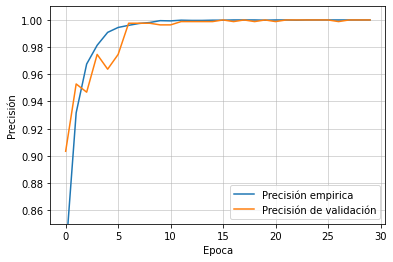

In [21]:
plt.plot(history.history['acc'], label='Precisión empirica')
plt.plot(history.history['val_acc'], label = 'Precisión de validación')
plt.xlabel('Epoca')
plt.ylabel('Precisión')
plt.grid(linewidth=0.5)
ax=plt.gca()
plt.ylim([0.85, 1.01])
plt.legend(loc='lower right')
test_loss, test_acc,f1_score,recall = model.evaluate(x_test, y_test, verbose=2)
plt.savefig(PATH+'/drive/My Drive/Colab Notebooks/Machine Learning/Proyecto 1/Graficas/Problema Dificil/precision.png')

# Funcion de error: Entropía cruzada 

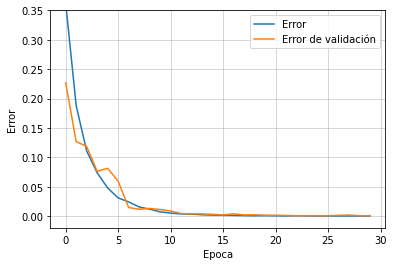

In [25]:
plt.plot(history.history['loss'], label='Error')
plt.plot(history.history['val_loss'], label = 'Error de validación')
plt.xlabel('Epoca')
plt.ylabel('Error')
plt.grid(linewidth=0.5)
ax=plt.gca()
plt.ylim([-0.02, 0.35])
plt.legend(loc='upper right')
plt.savefig(PATH+'/drive/My Drive/Colab Notebooks/Machine Learning/Proyecto 1/Graficas/Problema Dificil/Entropia Cruzada.png')
plt.show()

# F1 score 


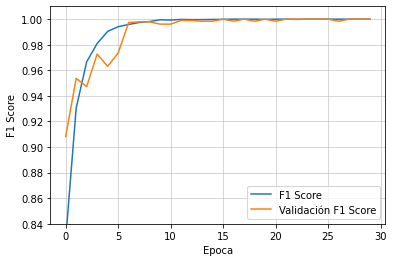

In [22]:
plt.plot(history.history['f1_m'], label='F1 Score')
plt.plot(history.history['val_f1_m'], label = 'Validación F1 Score')
plt.xlabel('Epoca')
plt.ylabel('F1 Score')
plt.grid(linewidth=0.5)
ax=plt.gca()
plt.ylim([0.84, 1.01])
plt.legend(loc='lower right')
plt.savefig(PATH+'/drive/My Drive/Colab Notebooks/Machine Learning/Proyecto 1/Graficas/Problema Dificil/F1 Score.png')
plt.show()

# Recall 


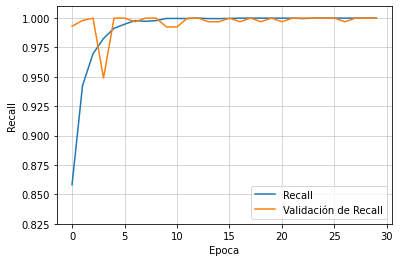

In [23]:
plt.plot(history.history['recall_m'], label='Recall')
plt.plot(history.history['val_recall_m'], label = 'Validación de Recall')
plt.xlabel('Epoca')
plt.ylabel('Recall')
plt.grid(linewidth=0.5)
ax=plt.gca()
plt.ylim([0.825, 1.01])
plt.legend(loc='lower right')
plt.savefig(PATH+'/drive/My Drive/Colab Notebooks/Machine Learning/Proyecto 1/Graficas/Problema Dificil/recall.png')
plt.show()

#Metricas sobre datos de prueba

In [0]:
print('Precisión: ',test_acc)
print('Error: ',test_loss)
print('F1 score: ',f1_score)
print('Recall: ',recall)

Precisión:  0.9981884057971014
Error:  0.008855311889161964
F1 score:  0.9981323947077212
Recall:  1.0


In [0]:
#from google.colab import output
#output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

Se utiliza el modelo entrenado para predecir los valores de Y sobre los datos de prueba, que son las predicciones del modelo. La salida de la función sigmoide es la probabilidad de pertenecer a la clase etiquetada como 1, por lo tanto establece un umbral de 0.5 para el cual si la probabilidad es mayor a 0.5, se elige la clase 1 y de lo contrario se elige la clase 0. Para esto se redondea a la cifra significativa mas cercana.

In [0]:
predtest=model.predict(x_test)
for i in range(predtest.shape[0]):
  if predtest[i]<0.5:
    predtest[i]=0
  else:
    predtest[i]=1

Ahora se comparan los resultados sobre los datos de prueba de la predicción del modelo con respecto a las etiquetas reales de las imagenes. 


Salida de sigmoide (Predicción):  0.0  que es la etiqueta de el:  Mundo 2 



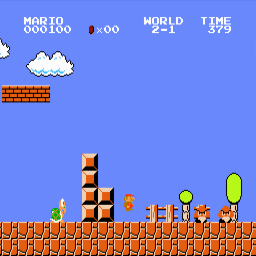



Etiqueta verdadera:  0 que es la etiqueta de el:  Mundo 2 

Acierto!
-----------------------------------------------------
Salida de sigmoide (Predicción):  0.0  que es la etiqueta de el:  Mundo 2 



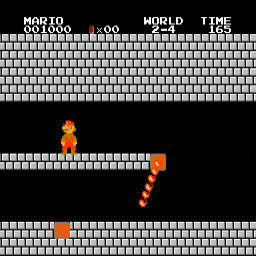



Etiqueta verdadera:  0 que es la etiqueta de el:  Mundo 2 

Acierto!
-----------------------------------------------------
Salida de sigmoide (Predicción):  1.0  que es la etiqueta de el:  Mundo 1 



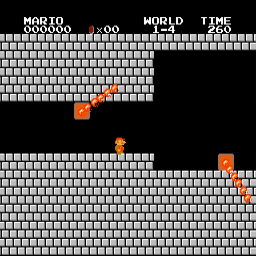



Etiqueta verdadera:  1 que es la etiqueta de el:  Mundo 1 

Acierto!
-----------------------------------------------------
Salida de sigmoide (Predicción):  0.0  que es la etiqueta de el:  Mundo 2 



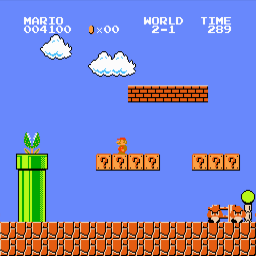



Etiqueta verdadera:  0 que es la etiqueta de el:  Mundo 2 

Acierto!
-----------------------------------------------------
Salida de sigmoide (Predicción):  1.0  que es la etiqueta de el:  Mundo 1 



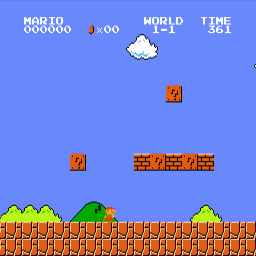



Etiqueta verdadera:  1 que es la etiqueta de el:  Mundo 1 

Acierto!
-----------------------------------------------------
Salida de sigmoide (Predicción):  1.0  que es la etiqueta de el:  Mundo 1 



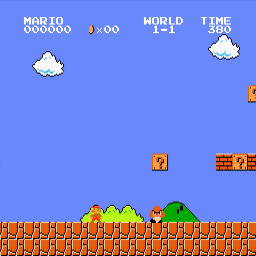



Etiqueta verdadera:  1 que es la etiqueta de el:  Mundo 1 

Acierto!
-----------------------------------------------------
Salida de sigmoide (Predicción):  1.0  que es la etiqueta de el:  Mundo 1 



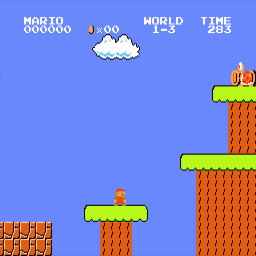



Etiqueta verdadera:  1 que es la etiqueta de el:  Mundo 1 

Acierto!
-----------------------------------------------------
Salida de sigmoide (Predicción):  0.0  que es la etiqueta de el:  Mundo 2 



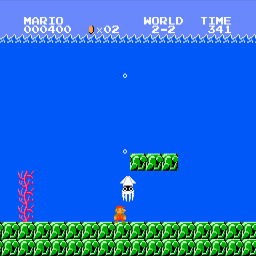



Etiqueta verdadera:  0 que es la etiqueta de el:  Mundo 2 

Acierto!
-----------------------------------------------------
Salida de sigmoide (Predicción):  1.0  que es la etiqueta de el:  Mundo 1 



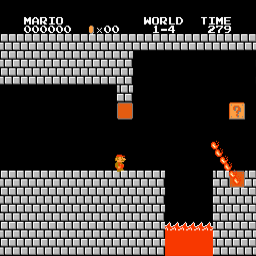



Etiqueta verdadera:  1 que es la etiqueta de el:  Mundo 1 

Acierto!
-----------------------------------------------------
Salida de sigmoide (Predicción):  0.0  que es la etiqueta de el:  Mundo 2 



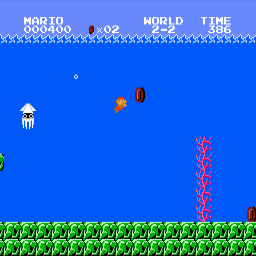



Etiqueta verdadera:  0 que es la etiqueta de el:  Mundo 2 

Acierto!
-----------------------------------------------------
Salida de sigmoide (Predicción):  0.0  que es la etiqueta de el:  Mundo 2 



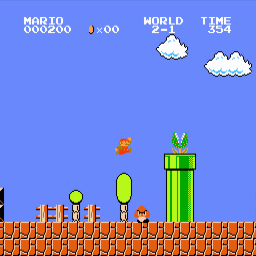



Etiqueta verdadera:  0 que es la etiqueta de el:  Mundo 2 

Acierto!
-----------------------------------------------------
Salida de sigmoide (Predicción):  0.0  que es la etiqueta de el:  Mundo 2 



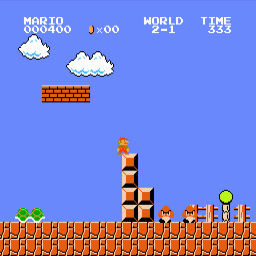



Etiqueta verdadera:  0 que es la etiqueta de el:  Mundo 2 

Acierto!
-----------------------------------------------------
Salida de sigmoide (Predicción):  0.0  que es la etiqueta de el:  Mundo 2 



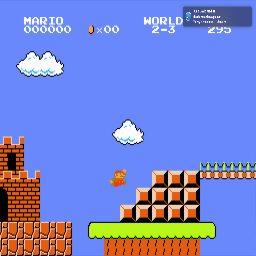



Etiqueta verdadera:  0 que es la etiqueta de el:  Mundo 2 

Acierto!
-----------------------------------------------------
Salida de sigmoide (Predicción):  1.0  que es la etiqueta de el:  Mundo 1 



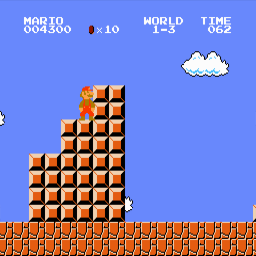



Etiqueta verdadera:  1 que es la etiqueta de el:  Mundo 1 

Acierto!
-----------------------------------------------------
Salida de sigmoide (Predicción):  0.0  que es la etiqueta de el:  Mundo 2 



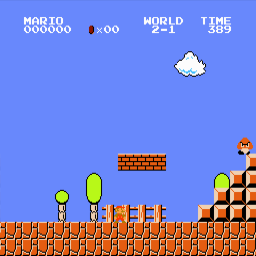



Etiqueta verdadera:  0 que es la etiqueta de el:  Mundo 2 

Acierto!
-----------------------------------------------------
Salida de sigmoide (Predicción):  0.0  que es la etiqueta de el:  Mundo 2 



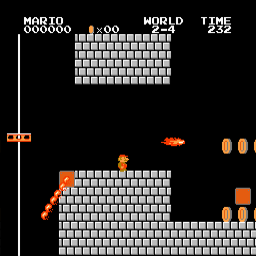



Etiqueta verdadera:  0 que es la etiqueta de el:  Mundo 2 

Acierto!
-----------------------------------------------------
Salida de sigmoide (Predicción):  1.0  que es la etiqueta de el:  Mundo 1 



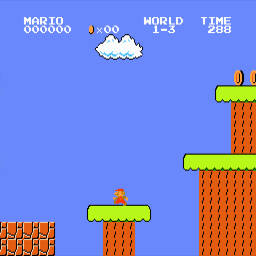



Etiqueta verdadera:  1 que es la etiqueta de el:  Mundo 1 

Acierto!
-----------------------------------------------------
Salida de sigmoide (Predicción):  0.0  que es la etiqueta de el:  Mundo 2 



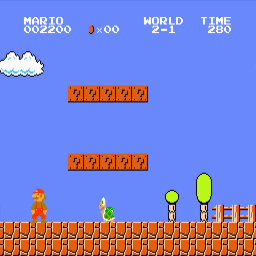



Etiqueta verdadera:  0 que es la etiqueta de el:  Mundo 2 

Acierto!
-----------------------------------------------------
Salida de sigmoide (Predicción):  0.0  que es la etiqueta de el:  Mundo 2 



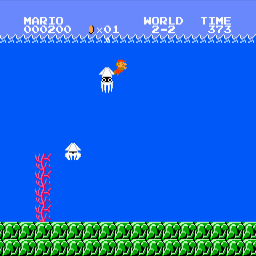



Etiqueta verdadera:  0 que es la etiqueta de el:  Mundo 2 

Acierto!
-----------------------------------------------------
Salida de sigmoide (Predicción):  0.0  que es la etiqueta de el:  Mundo 2 



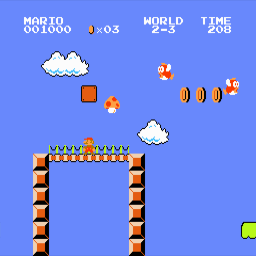



Etiqueta verdadera:  0 que es la etiqueta de el:  Mundo 2 

Acierto!
-----------------------------------------------------


In [0]:
for i in range(20):
  numAleatorio=randint(0,predtest.shape[0]-1)
  prediccion=predtest[numAleatorio][0]
  print('Salida de sigmoide (Predicción): ',prediccion,' que es la etiqueta de el: ',cualClase(prediccion),'\n')
  cv2_imshow(x_test[numAleatorio])
  print('\n')
  print('Etiqueta verdadera: ',y_test[numAleatorio],'que es la etiqueta de el: ', cualClase(y_test[numAleatorio]),'\n')
  if prediccion==y_test[numAleatorio]:
    print('Acierto!')
  else:
    print('Equivocado')
  print('-----------------------------------------------------')

Es de interes tener presente los datos en los cuales la red convolucional se ha equivocado, asi es posible analizar las razones por las cuales existen datos que el modelo no puede predecir con exactitud.

Se modelo se equivoca en 2 imagenes, las cuales en los 2 mundos distintos similitudes muy evidentes. 

La imagen  471 fue clasificada por el modelo como:  1.0 pero pertenece a la etiqueta:  0
La imagen  722 fue clasificada por el modelo como:  1.0 pero pertenece a la etiqueta:  0
La imagen  1511 fue clasificada por el modelo como:  1.0 pero pertenece a la etiqueta:  0


Imagen 471: 



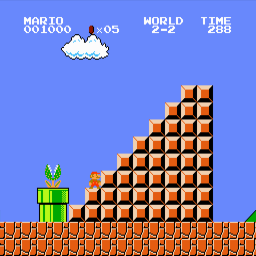



Similar a imagen del Mundo 1: 



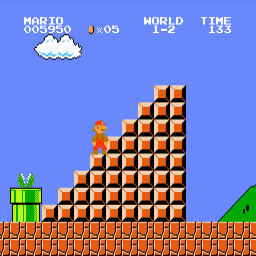



Imagen 772: 




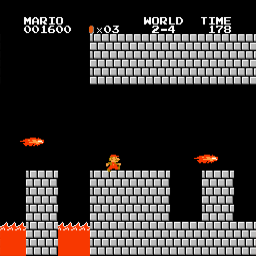



Similar a imagen del Mundo 1: 




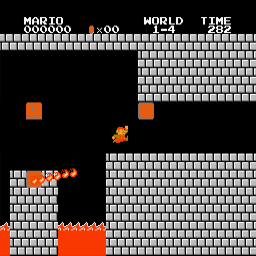

In [0]:
filas=[]
for row_index, (input, prediction, label) in enumerate(zip (x_test, predtest, y_test)):
  if prediction != label:
    print('La imagen ', row_index, 'fue clasificada por el modelo como: ', prediction[0], 'pero pertenece a la etiqueta: ', label)

print('\n')
print('Imagen 471: \n')    
cv2_imshow(x_test[471])
print('\n')
print('Similar a imagen del Mundo 1: \n')
cv2_imshow(loaded_xarray[1861])
print('\n')
print('Imagen 772: ')    
print('\n')
cv2_imshow(x_test[772])
print('\n')
print('Similar a imagen del Mundo 1: ')
print('\n')
cv2_imshow(loaded_xarray[3314])

Dado que se establecio un umbral y el vector de predicciones fue binarizado, se procede analizar la matriz de confusión

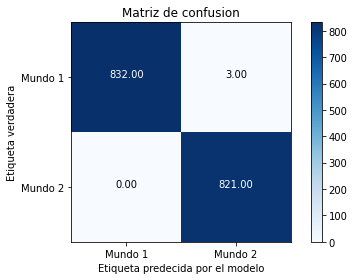

In [24]:
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Etiqueta verdadera')
    plt.xlabel('Etiqueta predecida por el modelo')
    plt.title('Matriz de confusion')
    plt.tight_layout()

conf=confusion_matrix(y_test.reshape((y_test.shape[0],1)),predtest.round())
plt.figure()
plot_confusion_matrix(conf, classes=['Mundo 1','Mundo 2'])
plt.savefig(PATH+'/drive/My Drive/Colab Notebooks/Machine Learning/Proyecto 1/Graficas/Problema Dificil/confusion.png')

In [0]:
print(classification_report(y_test.reshape((y_test.shape[0],1)), predtest.round()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       835
           1       1.00      1.00      1.00       821

    accuracy                           1.00      1656
   macro avg       1.00      1.00      1.00      1656
weighted avg       1.00      1.00      1.00      1656

